In [136]:
import sys

sys.path.append("../src/")
import mlflow
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mlflow.tracking import MlflowClient
from scipy.stats import pearsonr

client = MlflowClient(tracking_uri="http://localhost:5000")
experiment_id_mapping = experiment_id_mapping = {
    "cifar10-resnet": "206",
    "cifar100-resnet": "210",
    "mufac-resnet": "208",
    "cifar10-vit": "211",
    "cifar100-vit": "212",
    "mufac-vit": "213",
}

experiment_alpha_mapping = {
    "cifar10-resnet": "128.0",
    "cifar100-resnet": "2.0",
    "mufac-resnet": "4.0",
    "cifar10-vit": "8.0",
    "cifar100-vit": "8.0",
    "mufac-vit": "2.0",
}

def get_results(experiment_name):
    experiment_id = experiment_id_mapping[experiment_name]
    alpha = experiment_alpha_mapping[experiment_name]
    methods = [
        "original",
        "retrained",
        "finetune",
        "neggrad",
        "relabel",
        "badT",
        "scrub",
        "ssd",
        "unsir",
    ]
    metrics = ["mia", "acc_forget", "acc_retain", "acc_test", "t", "js", "js_proxy"]
    runs = client.search_runs(experiment_id)
    df = pd.DataFrame(
        [
            {k: v for k, v in run.data.metrics.items() if k in metrics}
            for run in runs
            if run.data.tags.get("mlflow.runName") in methods
            or (
                run.data.tags.get("mlflow.runName") == "our"
                and run.data.params.get("alpha") == str(alpha)
            )
        ]
    )
    df["method"] = [
        run.data.tags.get("mlflow.runName")
        for run in runs
        if run.data.tags.get("mlflow.runName") in methods
        or (
            run.data.tags.get("mlflow.runName") == "our"
            and run.data.params.get("alpha") == str(alpha)
        )
    ]

    df["seed"] = [
        run.data.params.get("seed")
        for run in runs
        if run.data.tags.get("mlflow.runName") in methods
        or (
            run.data.tags.get("mlflow.runName") == "our"
            and run.data.params.get("alpha") == str(alpha)
        )
    ]

    df.set_index(["method", "seed"], inplace=True)

    gap_metrics = ["mia", "acc_forget", "acc_retain", "acc_test"]
    for method in [
        "finetune",
        "neggrad",
        "relabel",
        "badT",
        "scrub",
        "ssd",
        "unsir",
        "our",
    ]:
        for gap_metric in gap_metrics:
            for seed in df.index.get_level_values("seed").unique():
                df.loc[method, f"{gap_metric}_gap"] = abs(
                    df.loc[(method, seed), gap_metric]
                    - df.loc[("retrained", seed), gap_metric]
                )
    grouped_df = df.groupby("method").aggregate(["mean", "std"])
    grouped_df["js"] = grouped_df["js"].apply(lambda x: x * 1e4)
    grouped_df["js_proxy"] = grouped_df["js_proxy"].apply(lambda x: x * 1e4)
    grouped_df = grouped_df.round(2)
    grouped_df["avg_gap"] = (
        grouped_df[
            [
                ("mia_gap", "mean"),
                ("acc_retain_gap", "mean"),
                ("acc_forget_gap", "mean"),
                # ("acc_test_gap", "mean")
            ]
        ]
        .mean(axis=1)
        .round(4)
    )

    main_df = grouped_df.loc[
        ["finetune", "neggrad", "relabel", "badT", "scrub", "ssd", "unsir", "our"],
        ["avg_gap", "t", "js", "js_proxy"],
    ]
    appendix_df = grouped_df.loc[
        [
            "original",
            "retrained",
            "finetune",
            "neggrad",
            "relabel",
            "badT",
            "scrub",
            "ssd",
            "unsir",
            "our",
        ],
        [
            "mia",
            "mia_gap",
            "acc_forget",
            "acc_forget_gap",
            "acc_retain",
            "acc_retain_gap",
            "acc_test",
            "acc_test_gap",
            "avg_gap",
        ],
    ]

    print(experiment_name)
    corr, p_value = pearsonr(main_df[('avg_gap', '')], main_df[('js_proxy', 'mean')])
    print(f"Pearson correlation between avg_gap and js_proxy: {corr:.2f}, p-value: {p_value:.4f}")

    corr, p_value = pearsonr(main_df[('avg_gap', '')], main_df[('js', 'mean')])
    print(f"Pearson correlation between avg_gap and js: {corr:.2f}, p-value: {p_value:.4f}")

    corr, p_value = pearsonr(main_df[('js', 'mean')], main_df[('js_proxy', 'mean')])
    print(f"Pearson correlation between js and js_proxy: {corr:.2f}, p-value: {p_value:.4f}")
    display(main_df)
    display(appendix_df)

    return main_df, appendix_df

In [137]:
rn_cifar10, appendix_df = get_results("cifar10-resnet")

cifar10-resnet
Pearson correlation between avg_gap and js_proxy: 0.85, p-value: 0.0070
Pearson correlation between avg_gap and js: 0.93, p-value: 0.0008
Pearson correlation between js and js_proxy: 0.89, p-value: 0.0031


avg_gap     t          js       js_proxy        
                  mean   std  mean   std     mean     std
method                                                   
finetune  0.1200  0.43  0.00  1.03  0.24    81.45    6.53
neggrad   0.1267  0.49  0.00  1.06  0.21    80.64   21.01
relabel   0.1133  0.57  0.00  1.00  0.26    47.98    3.43
badT      0.5133  0.33  0.00  2.39  2.03   287.45  157.93
scrub     0.1167  0.58  0.00  0.41  0.09    62.39    5.54
ssd       0.0500  0.54  0.00  0.82  0.57   145.86  152.88
unsir     0.1067  0.45  0.00  0.65  0.05    17.29    4.21
our       0.0400  0.30  0.01  0.39  0.11    18.90   16.41

mia       mia_gap      acc_forget       acc_forget_gap       \
           mean   std    mean  std       mean   std           mean  std   
method                                                                    
original   0.94  0.00     NaN  NaN       1.00  0.00            NaN  NaN   
retrained  0.76  0.03     NaN  NaN       0.91  0.02            NaN  NaN   
finetune   0.30  0.26    0.27  0.0       0.97  0.01           0.08  0.0   
neggrad    0.48  0.50    0.29  0.0       0.97  0.01           0.08  0.0   
relabel    0.48  0.50    0.27  0.0       0.96  0.01           0.06  0.0   
badT       0.43  0.37    0.73  0.0       0.71  0.18           0.37  0.0   
scrub      0.94  0.01    0.20  0.0       1.00  0.00           0.11  0.0   
ssd        0.81  0.11    0.09  0.0       0.86  0.16           0.03  0.0   
unsir      0.46  0.03    0.25  0.0       0.93  0.01           0.03  0.0   
our        0.67  0.20    0.06  0.0       0.93  0.02           0.04  0.0   

          acc_retain       acc_retain_gap      acc_test       acc_test_gap  \
                mean   std           mean  std     mean   std         mean   
method                                                                       
original        1.00  0.00            NaN  NaN     0.93  0.01          NaN   
retrained       0.99  0.02            NaN  NaN     0.91  0.02          NaN   
finetune        0.98  0.01           0.01  0.0     0.89  0.02         0.01   
neggrad         0.97  0.01           0.01  0.0     0.88  0.02         0.01   
relabel         0.97  0.01           0.01  0.0     0.89  0.02         0.01   
badT            0.71  0.18           0.44  0.0     0.66  0.16         0.40   
scrub           1.00  0.00           0.04  0.0     0.93  0.01         0.03   
ssd             0.87  0.16           0.03  0.0     0.80  0.15         0.04   
unsir           0.93  0.01           0.04  0.0     0.86  0.01         0.04   
our             0.98  0.01           0.02  0.0     0.90  0.01         0.01   

               avg_gap  
           std          
method                  
original   NaN     NaN  
retrained  NaN     NaN  
finetune   0.0  0.1200  
neggrad    0.0  0.1267  
relabel    0.0  0.1133  
badT       0.0  0.5133  
scrub      0.0  0.1167  
ssd        0.0  0.0500  
unsir      0.0  0.1067  
our        0.0  0.0400

In [138]:
rn_cifar100, appendix_df = get_results("cifar100-resnet")

cifar100-resnet
Pearson correlation between avg_gap and js_proxy: 0.75, p-value: 0.0329
Pearson correlation between avg_gap and js: 0.76, p-value: 0.0297
Pearson correlation between js and js_proxy: 0.99, p-value: 0.0000


avg_gap     t          js       js_proxy       
                  mean   std  mean   std     mean    std
method                                                  
finetune  0.3867  0.43  0.00  6.88  0.59   101.26  19.61
neggrad   0.3867  0.49  0.00  6.87  0.62   101.75  19.85
relabel   0.4500  0.57  0.00  5.84  0.98    74.93  20.53
badT      0.4667  0.34  0.01  4.30  0.49    63.04   8.91
scrub     0.1900  0.58  0.00  1.87  0.08    18.79   1.96
ssd       0.1467  0.54  0.00  3.04  1.55    42.17  36.59
unsir     0.3667  0.45  0.00  3.05  0.32    40.02   8.51
our       0.1133  0.30  0.01  1.29  0.03     8.35   0.19

mia       mia_gap      acc_forget       acc_forget_gap       \
           mean   std    mean  std       mean   std           mean  std   
method                                                                    
original   0.77  0.05     NaN  NaN       0.93  0.04            NaN  NaN   
retrained  0.49  0.01     NaN  NaN       0.57  0.02            NaN  NaN   
finetune   0.00  0.00    0.50  0.0       0.40  0.06           0.16  0.0   
neggrad    0.00  0.00    0.50  0.0       0.41  0.06           0.15  0.0   
relabel    0.00  0.00    0.50  0.0       0.31  0.06           0.28  0.0   
badT       0.33  0.58    0.50  0.0       0.27  0.03           0.28  0.0   
scrub      0.78  0.05    0.22  0.0       0.93  0.03           0.32  0.0   
ssd        0.59  0.05    0.09  0.0       0.50  0.32           0.03  0.0   
unsir      0.00  0.00    0.50  0.0       0.40  0.07           0.13  0.0   
our        0.55  0.01    0.05  0.0       0.89  0.04           0.27  0.0   

          acc_retain       acc_retain_gap      acc_test       acc_test_gap  \
                mean   std           mean  std     mean   std         mean   
method                                                                       
original        0.93  0.03            NaN  NaN     0.60  0.02          NaN   
retrained       0.94  0.03            NaN  NaN     0.60  0.02          NaN   
finetune        0.41  0.06           0.50  0.0     0.35  0.05         0.26   
neggrad         0.41  0.06           0.51  0.0     0.35  0.05         0.26   
relabel         0.37  0.07           0.57  0.0     0.31  0.06         0.32   
badT            0.28  0.03           0.62  0.0     0.25  0.03         0.34   
scrub           0.93  0.03           0.03  0.0     0.60  0.02         0.03   
ssd             0.50  0.32           0.32  0.0     0.36  0.20         0.17   
unsir           0.41  0.07           0.47  0.0     0.34  0.04         0.25   
our             0.93  0.03           0.02  0.0     0.62  0.01         0.00   

               avg_gap  
           std          
method                  
original   NaN     NaN  
retrained  NaN     NaN  
finetune   0.0  0.3867  
neggrad    0.0  0.3867  
relabel    0.0  0.4500  
badT       0.0  0.4667  
scrub      0.0  0.1900  
ssd        0.0  0.1467  
unsir      0.0  0.3667  
our        0.0  0.1133

In [139]:
rn_mufac, appendix_df = get_results("mufac-resnet")

mufac-resnet
Pearson correlation between avg_gap and js_proxy: -0.12, p-value: 0.7784
Pearson correlation between avg_gap and js: 0.02, p-value: 0.9675
Pearson correlation between js and js_proxy: 0.97, p-value: 0.0001


avg_gap     t           js       js_proxy        
                  mean   std   mean   std     mean     std
method                                                    
finetune  0.1767  0.76  0.00  19.52  6.23  1439.18  233.65
neggrad   0.1733  0.91  0.00  19.16  5.31  1546.01  156.39
relabel   0.2200  1.06  0.00   9.51  2.39   444.89   73.01
badT      0.0867  0.66  0.00  10.31  1.56   456.88   57.50
scrub     0.2433  1.20  0.00  10.53  2.31   254.92  131.48
ssd       0.2433  1.07  0.00  10.30  2.28   243.30  142.87
unsir     0.1667  1.68  0.02  16.32  4.82   988.15  120.39
our       0.1267  0.62  0.00   6.31  1.56   124.65   14.87

mia       mia_gap      acc_forget       acc_forget_gap       \
           mean   std    mean  std       mean   std           mean  std   
method                                                                    
original   0.70  0.06     NaN  NaN       0.88  0.04            NaN  NaN   
retrained  0.48  0.04     NaN  NaN       0.47  0.04            NaN  NaN   
finetune   0.54  0.09    0.17  0.0       0.64  0.04           0.10  0.0   
neggrad    0.53  0.08    0.16  0.0       0.68  0.04           0.13  0.0   
relabel    0.33  0.31    0.45  0.0       0.66  0.04           0.11  0.0   
badT       0.34  0.01    0.11  0.0       0.55  0.06           0.02  0.0   
scrub      0.70  0.05    0.27  0.0       0.88  0.06           0.41  0.0   
ssd        0.70  0.06    0.27  0.0       0.87  0.06           0.41  0.0   
unsir      0.40  0.35    0.16  0.0       0.71  0.03           0.19  0.0   
our        0.38  0.04    0.04  0.0       0.85  0.05           0.34  0.0   

          acc_retain       acc_retain_gap      acc_test       acc_test_gap  \
                mean   std           mean  std     mean   std         mean   
method                                                                       
original        0.89  0.04            NaN  NaN     0.54  0.03          NaN   
retrained       0.89  0.04            NaN  NaN     0.56  0.02          NaN   
finetune        0.64  0.04           0.26  0.0     0.43  0.01         0.13   
neggrad         0.66  0.03           0.23  0.0     0.43  0.01         0.13   
relabel         0.80  0.03           0.10  0.0     0.47  0.02         0.11   
badT            0.78  0.05           0.13  0.0     0.48  0.02         0.10   
scrub           0.89  0.04           0.05  0.0     0.54  0.03         0.01   
ssd             0.89  0.05           0.05  0.0     0.54  0.03         0.01   
unsir           0.73  0.03           0.15  0.0     0.46  0.01         0.10   
our             0.84  0.07           0.00  0.0     0.53  0.05         0.01   

               avg_gap  
           std          
method                  
original   NaN     NaN  
retrained  NaN     NaN  
finetune   0.0  0.1767  
neggrad    0.0  0.1733  
relabel    0.0  0.2200  
badT       0.0  0.0867  
scrub      0.0  0.2433  
ssd        0.0  0.2433  
unsir      0.0  0.1667  
our        0.0  0.1267

In [140]:
vit_cifar10, appendix_df = get_results("cifar10-vit")

/tmp/ipykernel_408330/3234364114.py:93: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[(method, seed), gap_metric]
/tmp/ipykernel_408330/3234364114.py:94: PerformanceWarning: indexing past lexsort depth may impact performance.
  - df.loc[("retrained", seed), gap_metric]
/tmp/ipykernel_408330/3234364114.py:92: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[method, f"{gap_metric}_gap"] = abs(
/tmp/ipykernel_408330/3234364114.py:93: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[(method, seed), gap_metric]
/tmp/ipykernel_408330/3234364114.py:94: PerformanceWarning: indexing past lexsort depth may impact performance.
  - df.loc[("retrained", seed), gap_metric]
/tmp/ipykernel_408330/3234364114.py:92: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[method, f"{gap_metric}_gap"] = abs(
/tmp/ipykernel_408330/3234364114.py:93: PerformanceWarning: indexing past le

ValueError: cannot handle a non-unique multi-index!

In [78]:
vit_cifar100, appendix_df = get_results("cifar100-vit")

cifar100-vit
Pearson correlation between avg_gap and js_proxy: 0.81, p-value: 0.0159
Pearson correlation between avg_gap and js: 0.89, p-value: 0.0030
Pearson correlation between js and js_proxy: 0.92, p-value: 0.0014


avg_gap      t          js       js_proxy      
                   mean   std  mean   std     mean   std
method                                                  
finetune  0.0275  11.35  0.00  0.07  0.00     3.12  0.17
neggrad   0.0425  12.63  0.01  0.13  0.01     3.37  0.12
relabel   0.0200  12.79  0.02  0.06  0.00     2.74  0.17
badT      0.0375   9.18  0.27  0.17  0.01     3.80  0.22
scrub     0.0200  16.74  0.03  0.04  0.00     2.04  0.09
ssd       0.0200  13.67  0.02  0.04  0.00     2.08  0.13
unsir     0.0200  10.69  0.01  0.08  0.01     3.11  0.19
our       0.0150   7.02  0.01  0.03  0.00     1.83  0.06

mia       mia_gap      acc_forget       acc_forget_gap       \
           mean   std    mean  std       mean   std           mean  std   
method                                                                    
original   0.75  0.00     NaN  NaN       0.97  0.01            NaN  NaN   
retrained  0.72  0.00     NaN  NaN       0.92  0.00            NaN  NaN   
finetune   0.77  0.00    0.05  0.0       0.95  0.01           0.03  0.0   
neggrad    0.79  0.02    0.08  0.0       0.97  0.02           0.06  0.0   
relabel    0.74  0.01    0.03  0.0       0.94  0.00           0.02  0.0   
badT       0.66  0.01    0.06  0.0       0.90  0.01           0.02  0.0   
scrub      0.75  0.00    0.03  0.0       0.97  0.00           0.05  0.0   
ssd        0.75  0.01    0.03  0.0       0.96  0.01           0.05  0.0   
unsir      0.78  0.01    0.05  0.0       0.94  0.00           0.02  0.0   
our        0.71  0.00    0.01  0.0       0.97  0.01           0.05  0.0   

          acc_retain       acc_retain_gap      acc_test       acc_test_gap  \
                mean   std           mean  std     mean   std         mean   
method                                                                       
original        0.96  0.00            NaN  NaN     0.91  0.01          NaN   
retrained       0.96  0.00            NaN  NaN     0.91  0.00          NaN   
finetune        0.98  0.00           0.02  0.0     0.92  0.01         0.01   
neggrad         0.97  0.02           0.02  0.0     0.91  0.01         0.01   
relabel         0.98  0.00           0.02  0.0     0.92  0.00         0.01   
badT            0.91  0.00           0.05  0.0     0.89  0.01         0.02   
scrub           0.96  0.00           0.00  0.0     0.91  0.01         0.00   
ssd             0.96  0.00           0.00  0.0     0.91  0.00         0.00   
unsir           0.95  0.01           0.01  0.0     0.90  0.01         0.00   
our             0.96  0.00           0.00  0.0     0.91  0.00         0.00   

               avg_gap  
           std          
method                  
original   NaN     NaN  
retrained  NaN     NaN  
finetune   0.0  0.0275  
neggrad    0.0  0.0425  
relabel    0.0  0.0200  
badT       0.0  0.0375  
scrub      0.0  0.0200  
ssd        0.0  0.0200  
unsir      0.0  0.0200  
our        0.0  0.0150

In [79]:
vit_mufac, appendix_df = get_results("mufac-vit")

mufac-vit
Pearson correlation between avg_gap and js_proxy: 0.98, p-value: 0.0000
Pearson correlation between avg_gap and js: 0.97, p-value: 0.0001
Pearson correlation between js and js_proxy: 0.94, p-value: 0.0006


avg_gap     t          js       js_proxy        
                  mean   std  mean   std     mean     std
method                                                   
finetune  0.0300  1.40  0.01  0.27  0.02    18.46    6.75
neggrad   0.0375  1.67  0.00  0.39  0.04    20.68    6.78
relabel   0.0100  1.76  0.01  0.35  0.09    22.58    3.92
badT      0.2075  2.09  0.25  1.89  1.01   201.41  191.09
scrub     0.0150  2.21  0.01  0.05  0.02     8.27    0.60
ssd       0.0125  1.91  0.00  0.17  0.17    14.89    9.32
unsir     0.0575  3.21  0.01  0.85  0.06    23.52    8.34
our       0.0150  1.09  0.00  0.05  0.01    10.11    0.54

mia       mia_gap      acc_forget       acc_forget_gap       \
           mean   std    mean  std       mean   std           mean  std   
method                                                                    
original   0.58  0.01     NaN  NaN       0.63  0.01            NaN  NaN   
retrained  0.57  0.00     NaN  NaN       0.57  0.01            NaN  NaN   
finetune   0.52  0.08    0.02  0.0       0.61  0.01           0.03  0.0   
neggrad    0.52  0.07    0.02  0.0       0.66  0.02           0.07  0.0   
relabel    0.52  0.10    0.02  0.0       0.58  0.01           0.00  0.0   
badT       0.35  0.05    0.27  0.0       0.43  0.06           0.14  0.0   
scrub      0.59  0.01    0.02  0.0       0.62  0.01           0.03  0.0   
ssd        0.59  0.01    0.01  0.0       0.59  0.04           0.03  0.0   
unsir      0.47  0.08    0.13  0.0       0.58  0.01           0.01  0.0   
our        0.59  0.01    0.01  0.0       0.63  0.00           0.05  0.0   

          acc_retain       acc_retain_gap      acc_test       acc_test_gap  \
                mean   std           mean  std     mean   std         mean   
method                                                                       
original        0.66  0.01            NaN  NaN     0.66  0.01          NaN   
retrained       0.66  0.01            NaN  NaN     0.65  0.01          NaN   
finetune        0.72  0.01           0.05  0.0     0.66  0.01         0.02   
neggrad         0.71  0.01           0.04  0.0     0.65  0.03         0.02   
relabel         0.67  0.02           0.01  0.0     0.64  0.01         0.01   
badT            0.47  0.07           0.21  0.0     0.50  0.08         0.21   
scrub           0.66  0.01           0.00  0.0     0.66  0.01         0.01   
ssd             0.63  0.04           0.01  0.0     0.64  0.01         0.00   
unsir           0.72  0.01           0.07  0.0     0.63  0.02         0.02   
our             0.66  0.01           0.00  0.0     0.65  0.01         0.00   

               avg_gap  
           std          
method                  
original   NaN     NaN  
retrained  NaN     NaN  
finetune   0.0  0.0300  
neggrad    0.0  0.0375  
relabel    0.0  0.0100  
badT       0.0  0.2075  
scrub      0.0  0.0150  
ssd        0.0  0.0125  
unsir      0.0  0.0575  
our        0.0  0.0150

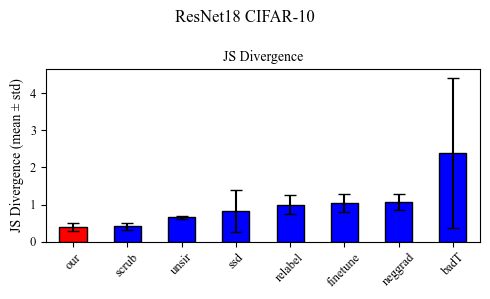

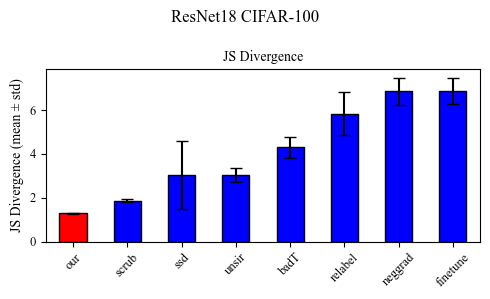

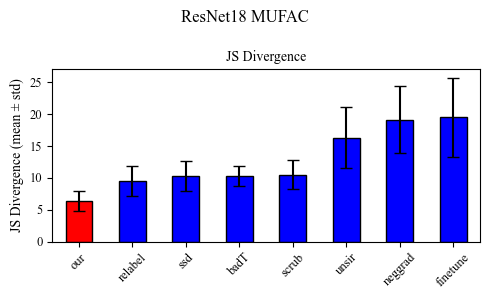

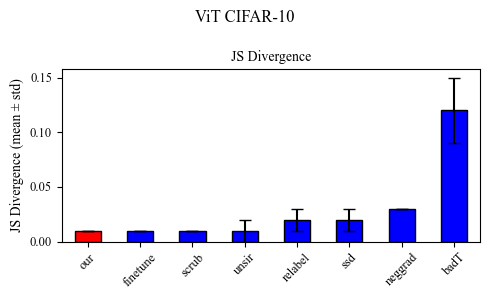

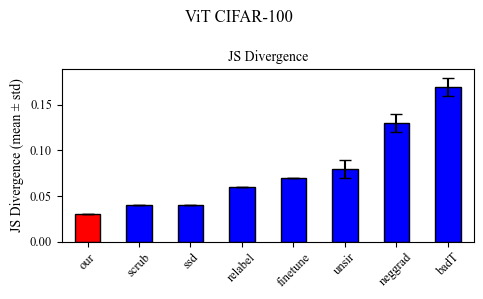

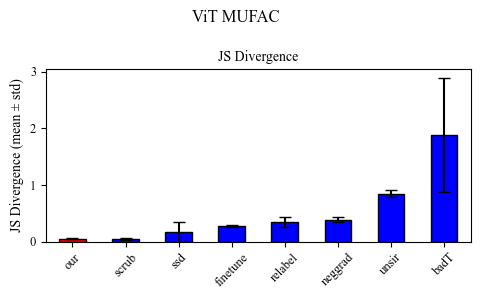

In [81]:
def plot_js_divergence(df, title):
    df_sorted_js = df.sort_values(by=('js', 'mean'), ascending=True, key=lambda x: x.where(df.index != 'our', x - 0.0001))
    
    fig, ax = plt.subplots(figsize=(5, 3))
    fig.suptitle(title, fontsize=12, fontname='Times New Roman')

    # Define colors for the bars
    colors_js = ['red' if method == 'our' else 'blue' for method in df_sorted_js.index]

    # Plot js
    df_sorted_js[('js', 'mean')].plot(kind='bar', yerr=df_sorted_js[('js', 'std')], ax=ax, color=colors_js, edgecolor='black', capsize=4)
    ax.set_title('JS Divergence', fontsize=10, fontname='Times New Roman')
    ax.set_xlabel(None)
    ax.set_ylabel('JS Divergence (mean ± std)', fontsize=10, fontname='Times New Roman')
    ax.tick_params(axis='x', rotation=45, labelsize=9)
    ax.tick_params(axis='y', labelsize=9)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname('Times New Roman')

    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.savefig(f'images/{title}_js_divergence.png', bbox_inches='tight', dpi=300)
    plt.show()

# Plot JS divergence for each dataframe
plot_js_divergence(rn_cifar10, "ResNet18 CIFAR-10")
plot_js_divergence(rn_cifar100, "ResNet18 CIFAR-100")
plot_js_divergence(rn_mufac, "ResNet18 MUFAC")
plot_js_divergence(vit_cifar10, "ViT CIFAR-10")
plot_js_divergence(vit_cifar100, "ViT CIFAR-100")
plot_js_divergence(vit_mufac, "ViT MUFAC")